- Filters before the mixer have a relatively large BW. Most filtering is done at the IF, so the Q value requirement is lower.
https://electronics.stackexchange.com/questions/153830/should-i-use-a-passive-or-an-active-filter
- Plan to use a simple LC circuit with a variable capacitor for tuning
- Maximum current in an LC circuit is given by V/sqrt(L/C)
- Choose L = 1 uH. Then for us to have a range of 88 MHz to 108 MHZ, We need a 1/(2*pi*sqrt(1*10^-6*C)) = 88*(10^6) for the lower bound and 1/(2*pi*sqrt(1*(10^-6)*C)) = 108*10^6 for the upper bound. 
- Using parallel LC (tank filter) since it has a very small passband. Approximating the band pass as an ideal filter only allowing a single frequency, we would need a capacitance range of 2.17 pF to 3.27 pF. To be safe let's choose a tunable cap between 1 pF and 5 pF. 


Impedance Matching

- Can use a variable capacitor for tuning the resonant frequency and another variable capacitor for matching, like so:
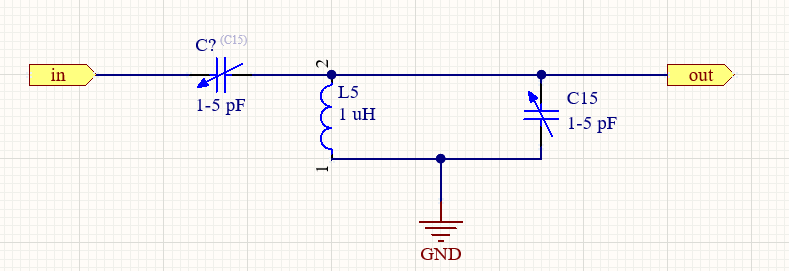

- At the resonant frequency, the (ideal) LC circuit impedance is 0! So the only impedance is due to the cap. Instead of using a tuning cap, we can just use a resistor, so that we don't have to tune two capacitors to set the frequency. Since the signal amplitude is relatively small since it is being received by an antenna from the air, we don't really have to worry about the power dissipation.
- The inductors and capacitors we are using both have a DC resistance of 360 mOhms. This means that at resonance the resistance will be 360||360 = 180 mOhms, and we want a 49.8 ohm resistor. 49.9 is close enough.

New circuit:

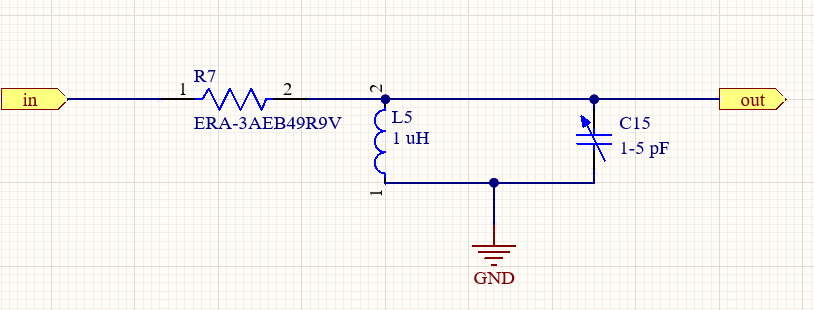

- Since the impedance to ground is very high the resonant frequency, the signal is able to pass from in to out unchanged.

Q factor

- It seems like the formula for the Q factor of a parallel LC resonant filter is given by 

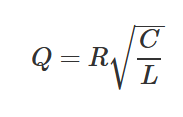

- This means that for an impedance of 50 ohms, the filter will have almost no attenuation at 88 MHz when tuned to 108 MHz. Do we need an impedance matching network here maybe?
- There are a few different options for impedance matching:
    1. Transformer matching - uses the ratio of the number of turns to transform impedances - good for high Q.
    2. L-network matching - uses and inductor + cap
    3. Tapped coil matching - this taps an inductor at a certain point. Good for high Q and gain.

- According to https://www.allaboutcircuits.com/textbook/radio-frequency-analysis-design/selected-topics/understanding-matching-networks/, the L-network is not suitable for high frequency applications. 100 MHz is mid-to-high frequency so let's go with a transformer matching circuit.
- According to https://info.triadmagnetics.com/hubfs/PDF_Offers/Impedance_Matching_Transformers_FINAL.pdf, the ratio of the number of turns for appropriate impedance matching is given by 

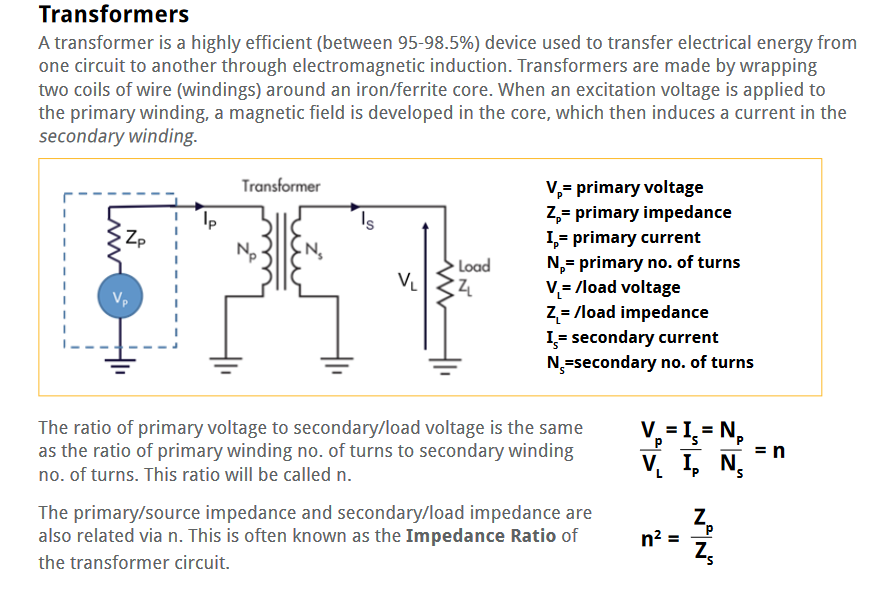

- For a reasonable Q factor, we need an input impedance of around 1Mohms. If our input impedance is 1M, and we want a load impedance of 50, then n^2 = 50/1M = 5*10^-5 => n = 0.007. This is far too high a value to reasonable acheive with a transformer. 
- According to perplexity, a better solution is to use a unity gain buffer amplifier to change the input impedance from a high value to a low value.


- Actually, we might just be able to adjust L and C to get a lower input impedance. For the frequency of 108 MHz, we need 1/(2*pi*sqrt(LC)) = fr = 108 MHz, and we also need R*sqrt(C/L) = Q factor = 5 (seems like a reasonable good starting point). R = 50 ohms for impedance matching. 
- Those two requirements give us two traces which intersect like this:

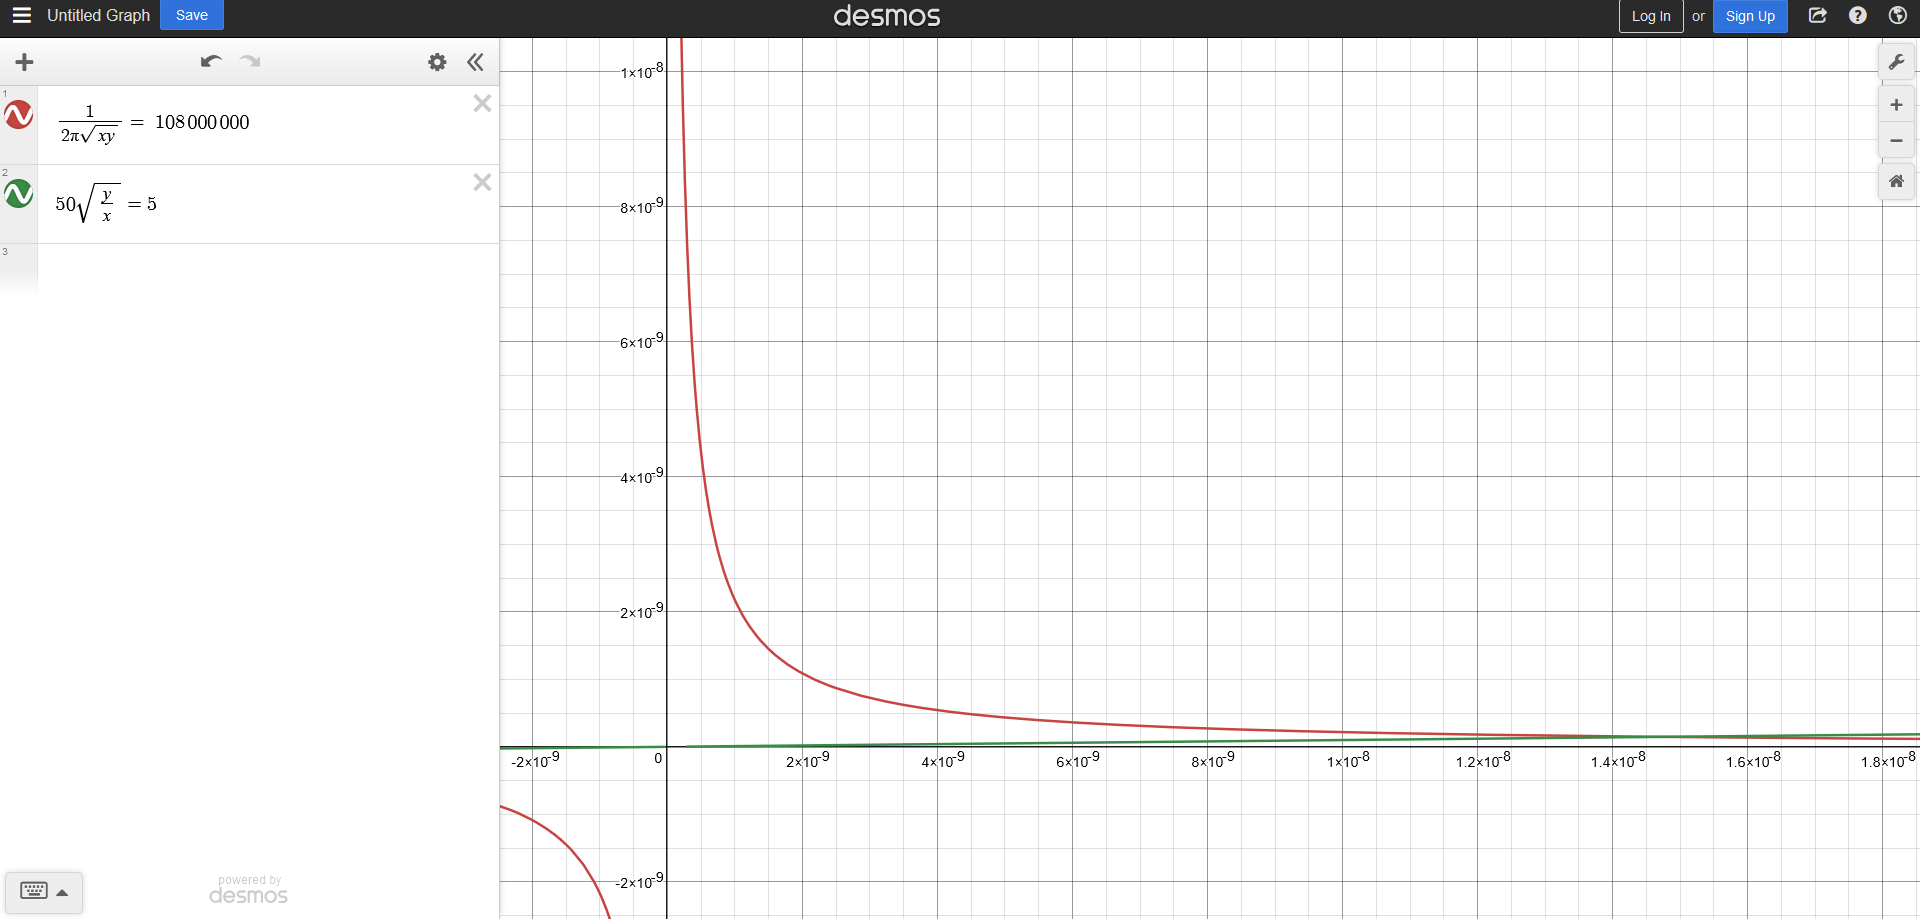


These two intersect at L = 1.47365 * 10^-8 H and C = 1.474 * 10^-10 F.

Let's try simulating this.

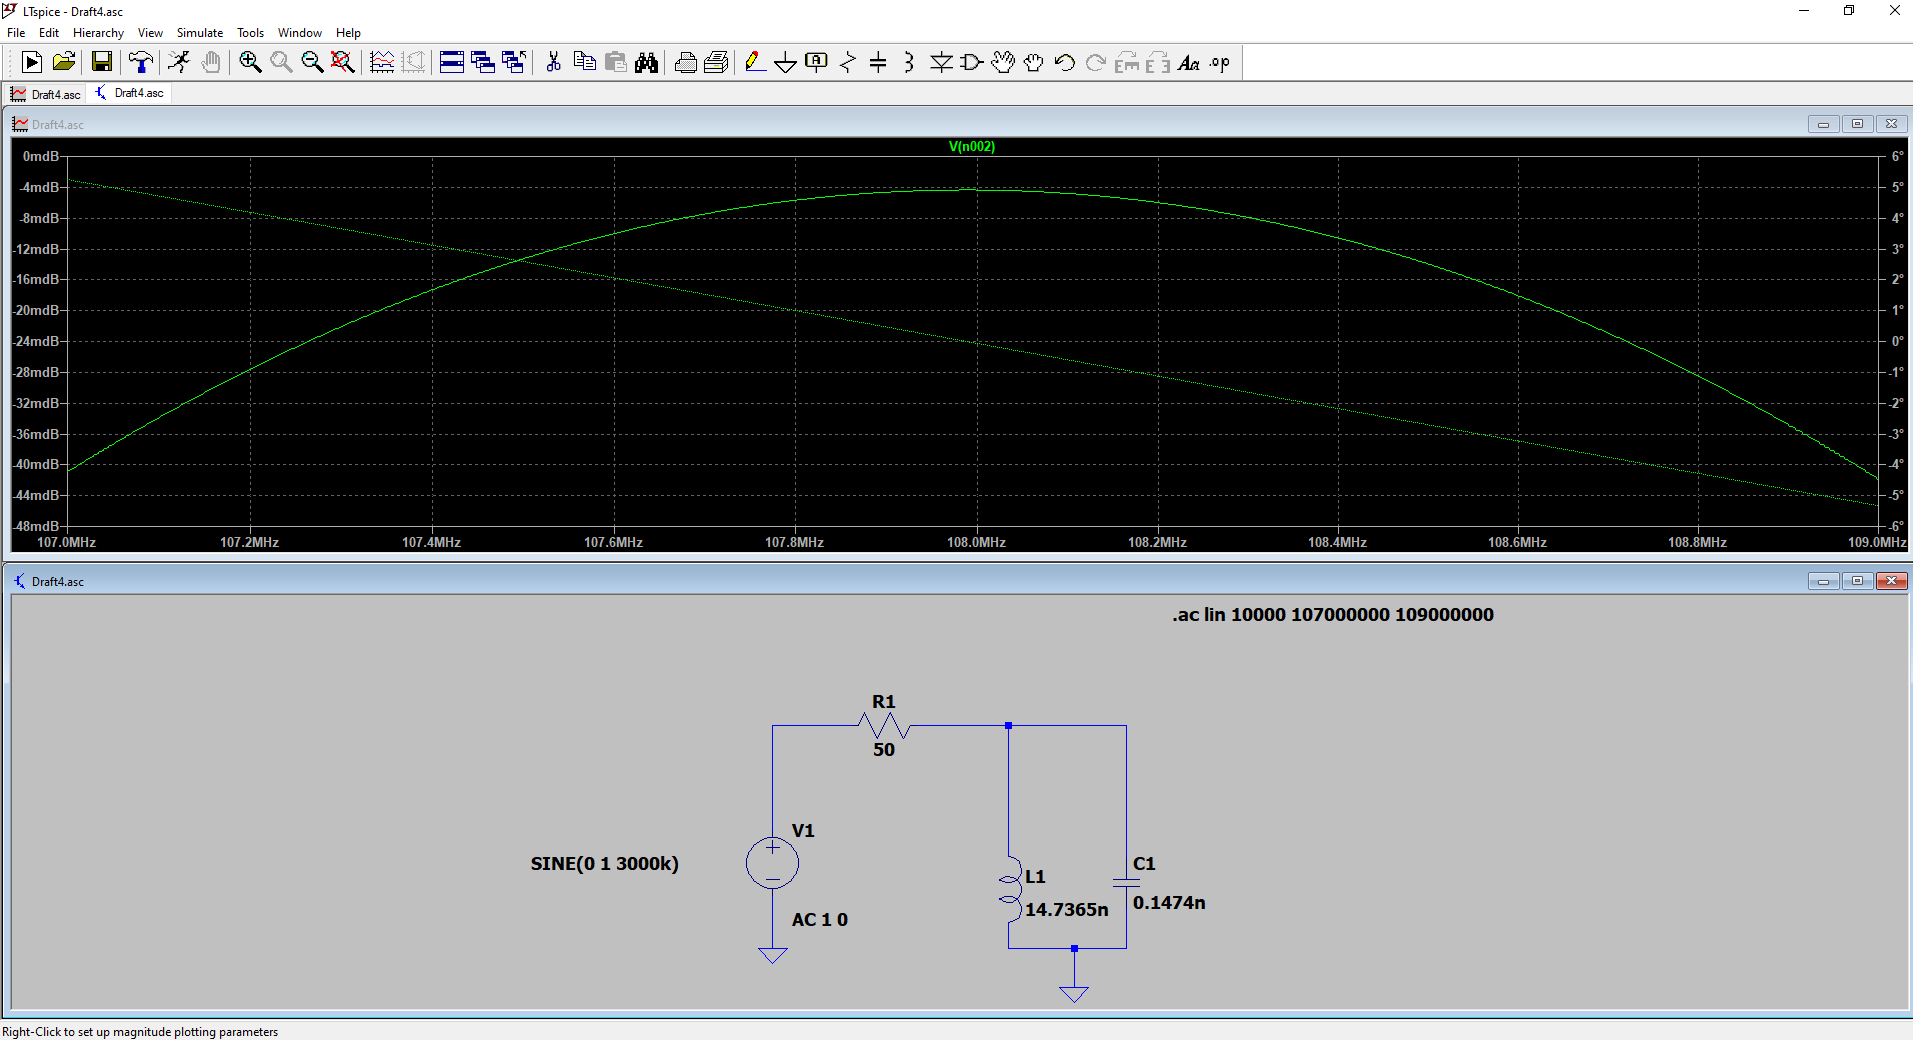

Clearly, this is not good enough since there's barely any attenuation at 107.8 MHz. Let's try Q = 5000. This gives us L = 1.4736569e-11 and C = 1.47365688e-7 F. Let's try simulating this.

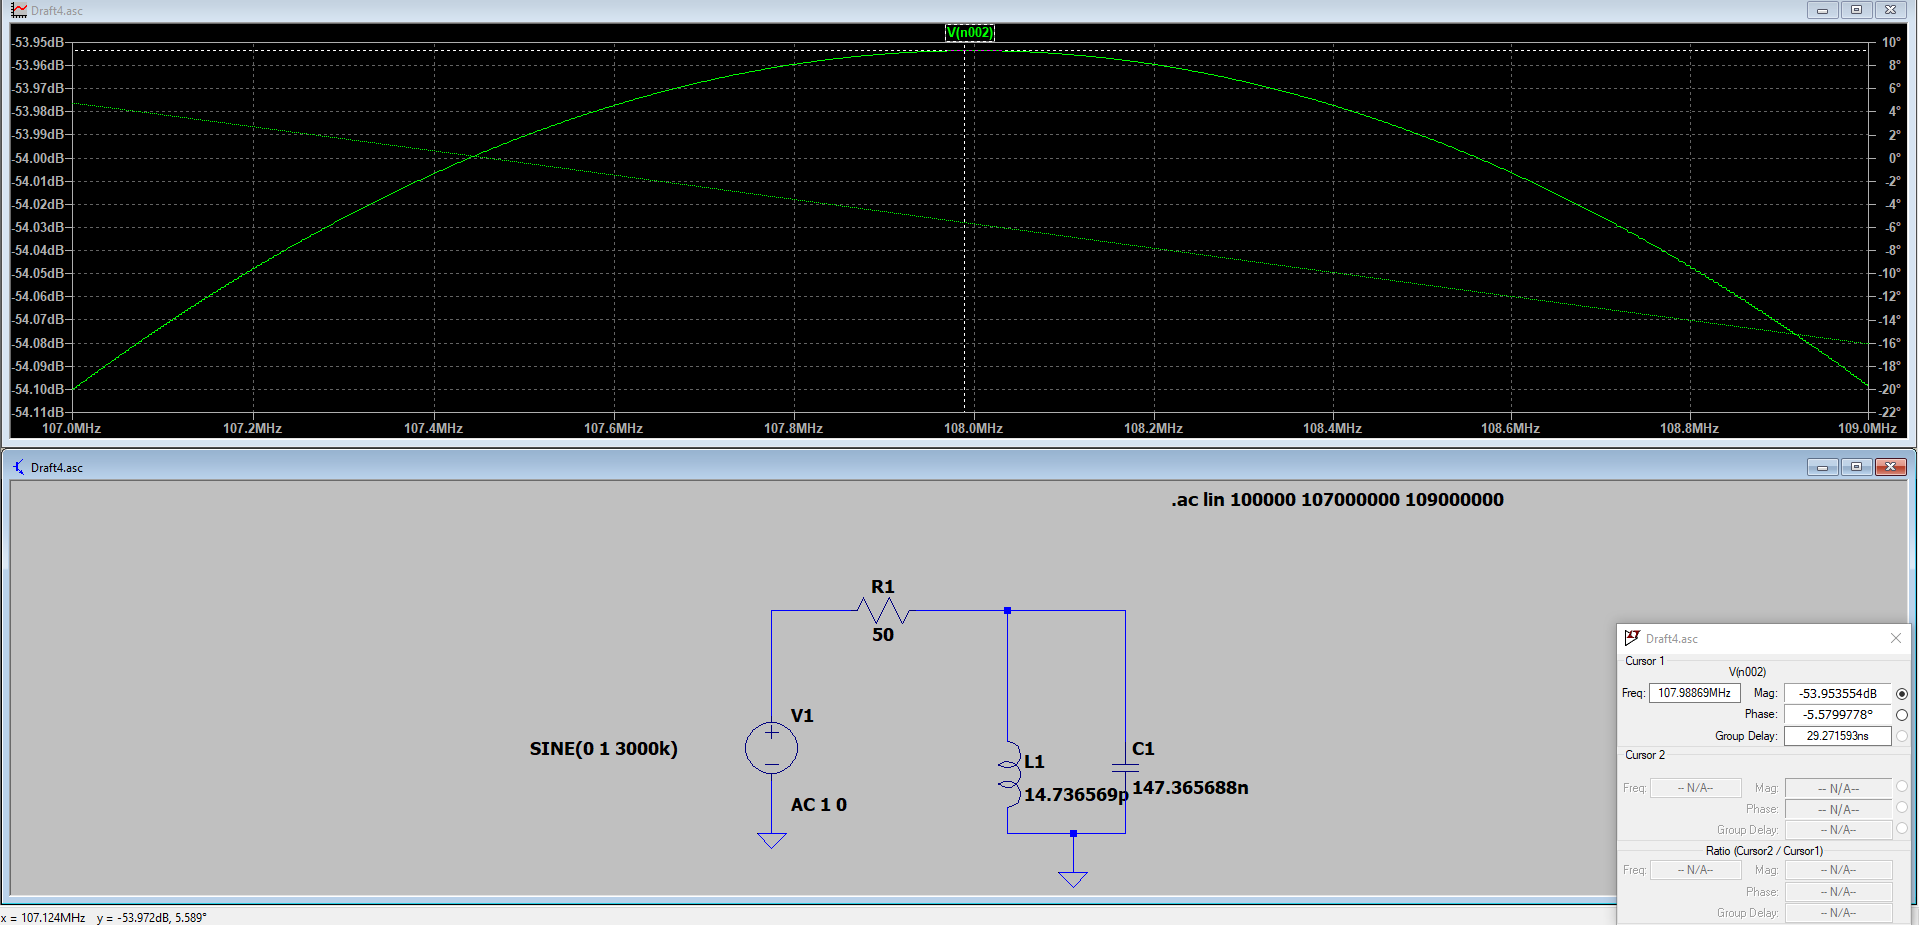

Why does the Q value online not match our simulations? According to perplexity, it seems like it has to do with the parasitics. I tried changing the series resistance of the inductor to a much smaller value and it resulted in a much sharper resonant freq. However, it's not really possible to get rid of parasitics - even the smallest values for DCR I found were around 1.3 mohms and didn't have the inductance I needed. 

- It seems like we can potentially combine multiple LC filters for a sharper response? Like a chebyshev filter?

- This website has a LC filter designer for chebyshev filters: https://markimicrowave.com/technical-resources/tools/lc-filter-design-tool/
- Upon some further research, it seems like Chebyshev filters are not a good choice since they have a variable group delay which can result in distortion. https://www.eevblog.com/forum/beginners/does-the-_shape_-of-an-fm-bandpass-filter-matter/
- Looks like the gain flatness doesn't matter too much.
- Bessel filters are the best since they have no group delay.
- Todo: replace the varactors in the bessel filter with the model SMV1130 in LTSPICE. 

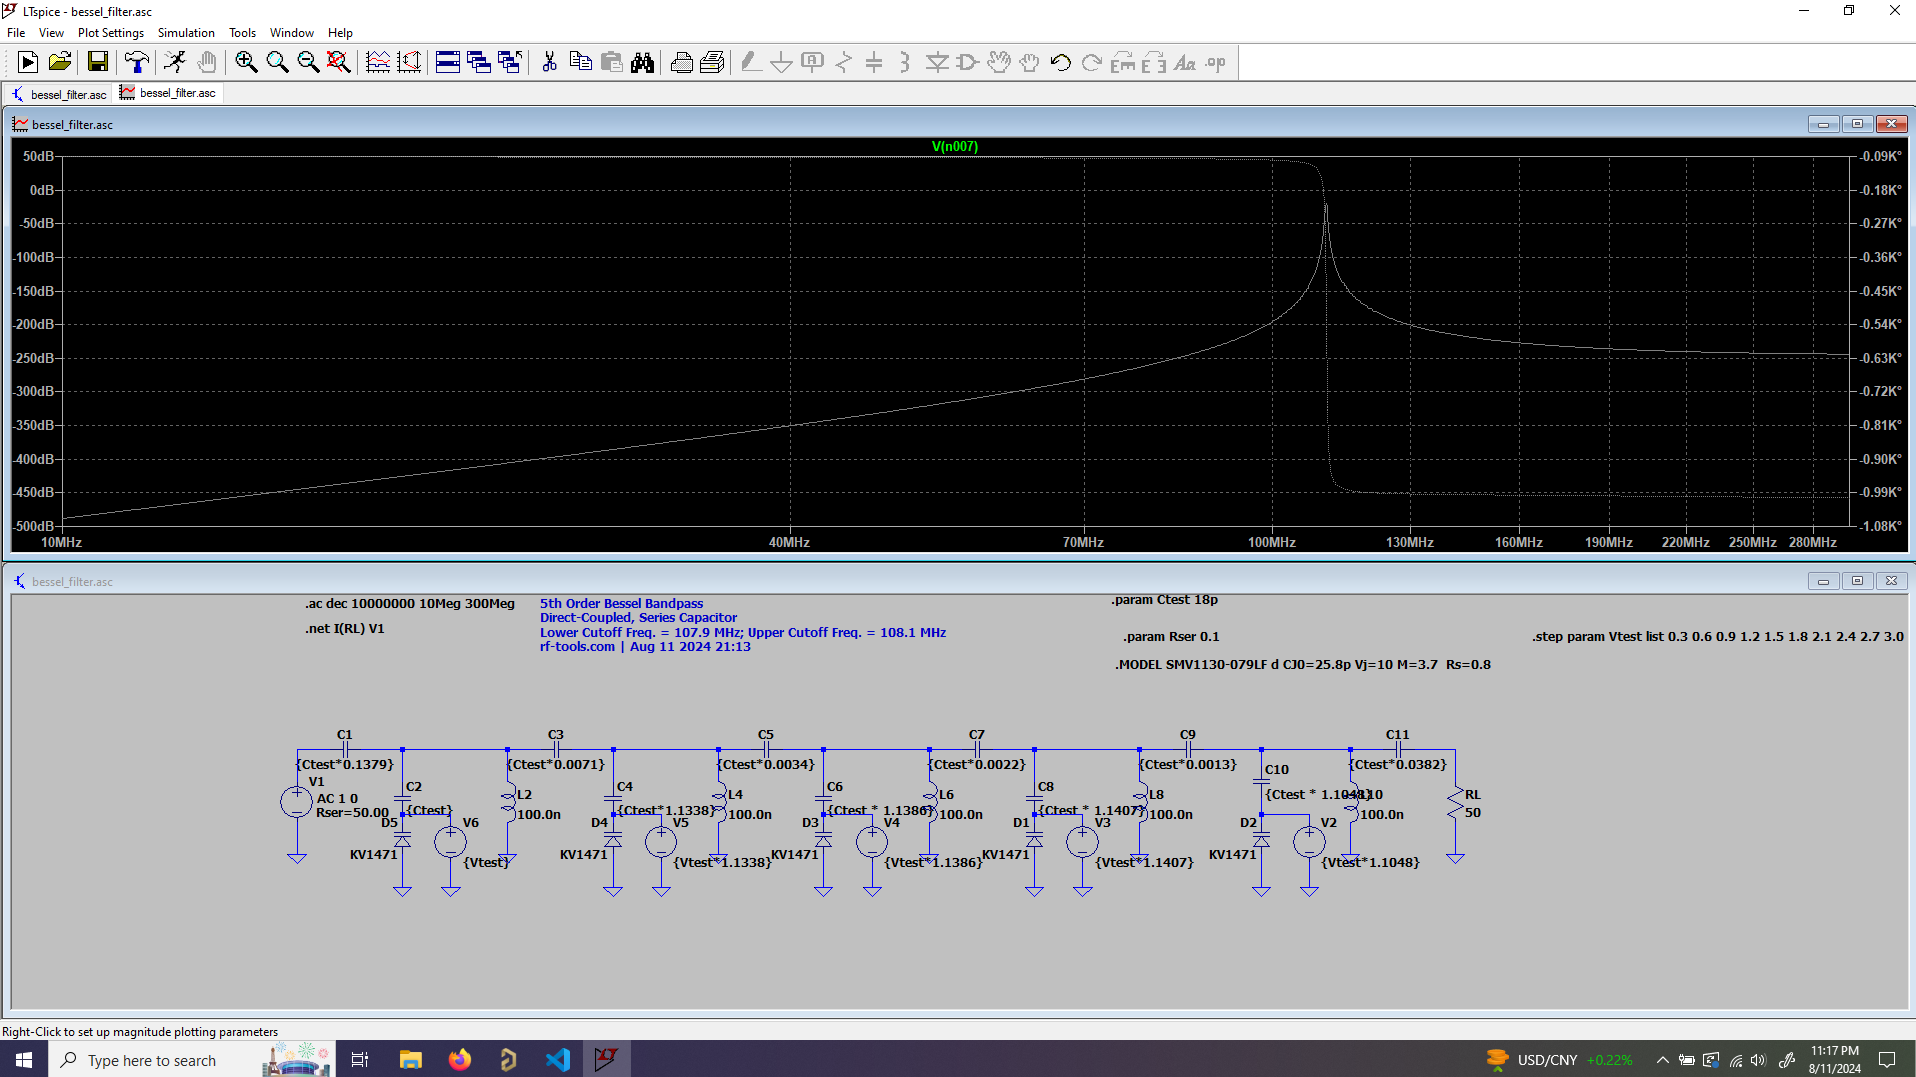


- Scaling all caps proportionally to change the bandpass center frequency results in distortion. See file:///C:/Users/piyus/Downloads/mar2000pg32.pdf for the proper way to tune a bandpass filter.

The following circuit works to tune the center frequency of the filter as a function of a scale factor, without changing the attenutation:
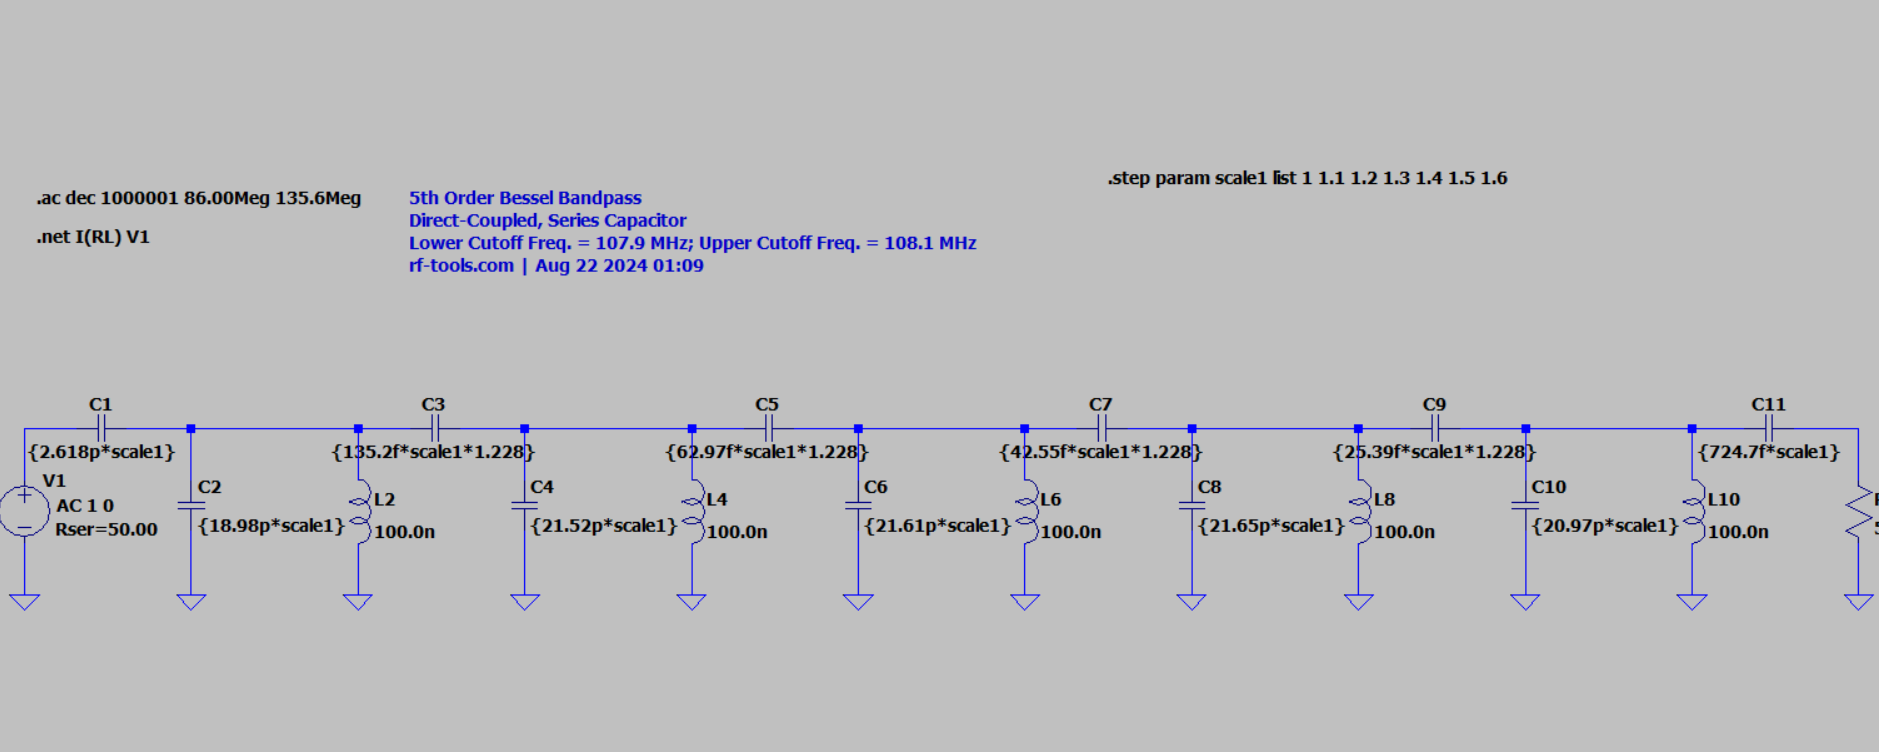

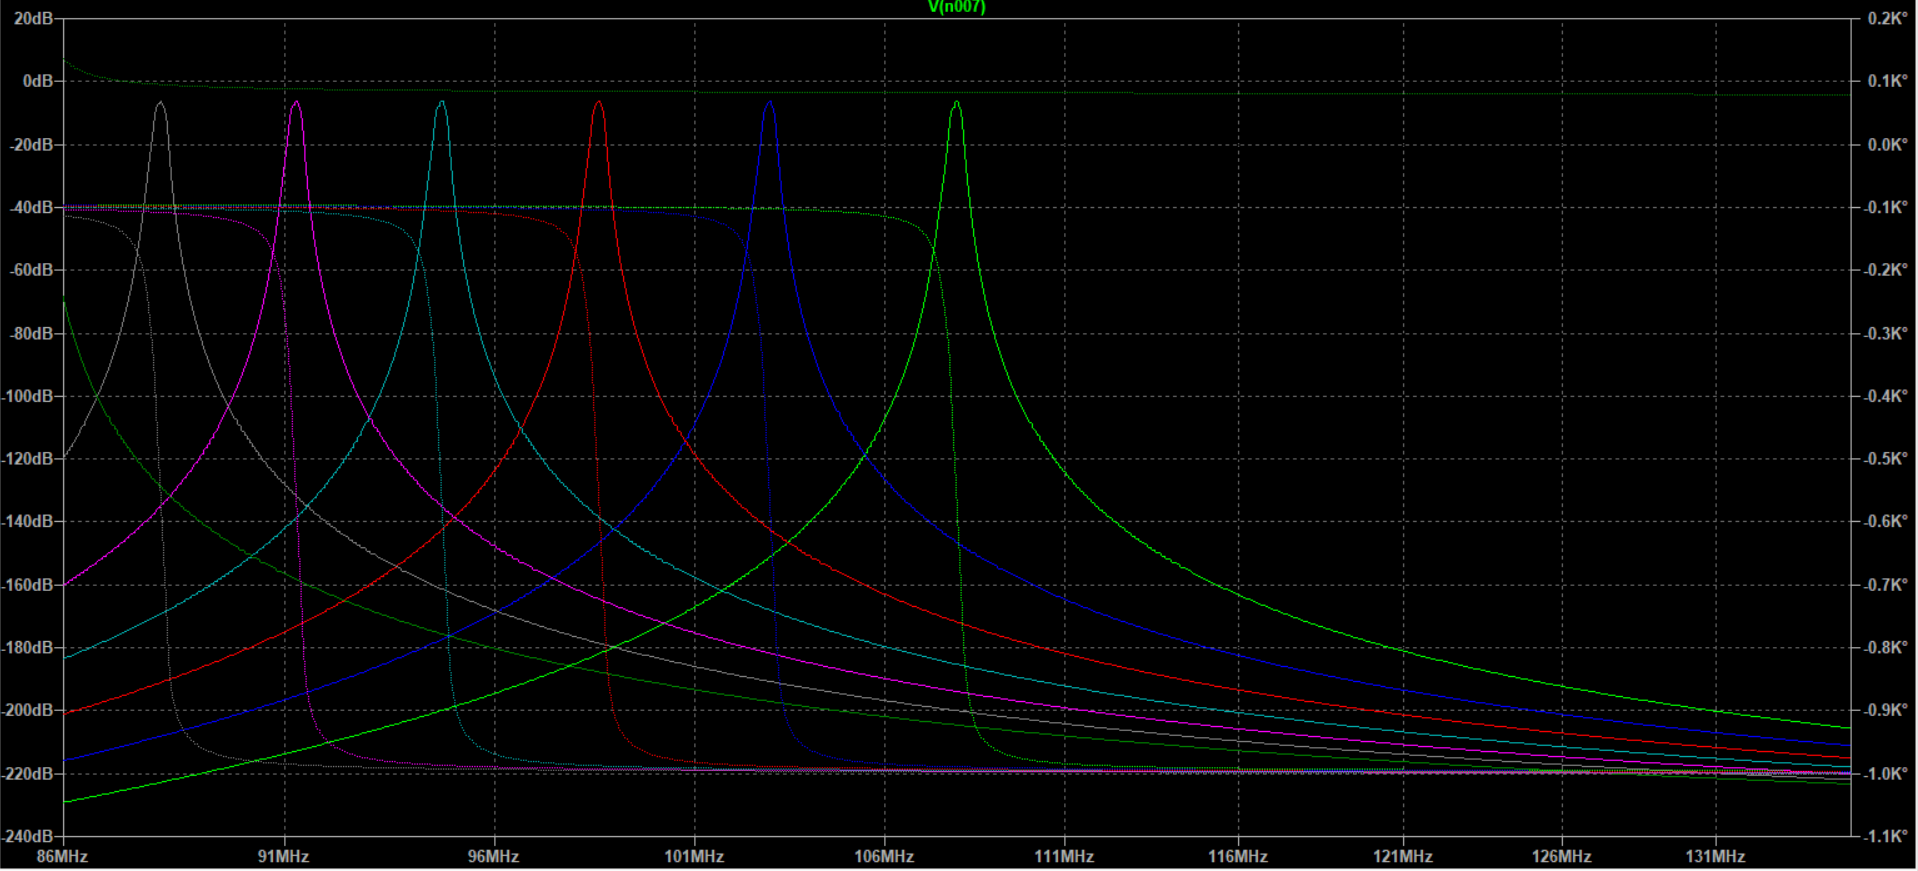

- Now we just need to change the caps to varactors. It seems like the finite resistor value in series with the voltage source creates a high pass filter. We can fix this by making the resistor very large.

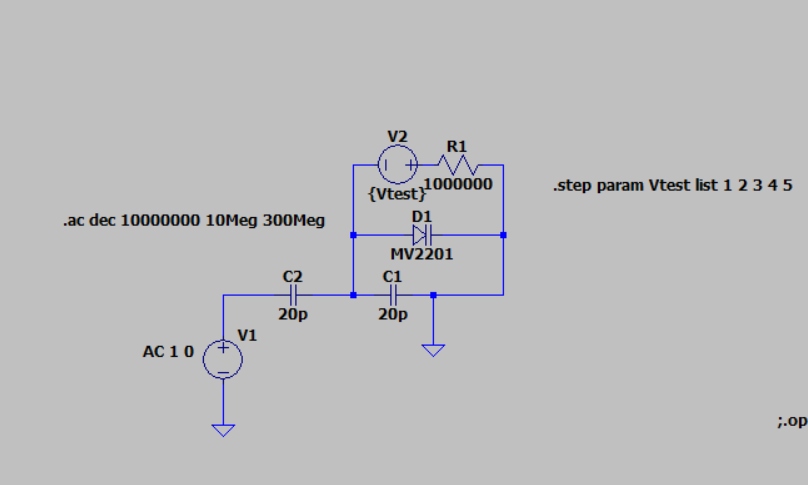

Also, to be more accurate, let's use 21.65 pF instead of since that's the maximum cap in our filter.
 
With just the cap divider and no varactor, a cap of 21.65 pF results in a voltage of -6.02 dB and a cap of 21.65*1.6 = 34.64 pF results in a voltage of -8.3 dB. 8.3 - 6.02 = 2.28 dB.

The lowest I could get it to go to (with a reverse bias of 0V) was -8.77 dB, and the highest (with a reverse bias of 5V) was -7.28 dB. 8.77 - 7.28 = 1.49 dB = 1.187. We need a change of 2.3 dB. Todo: try simulating the SMV1130 in varactor_parallel_test.asc, which supposedly has a large capacitance range.

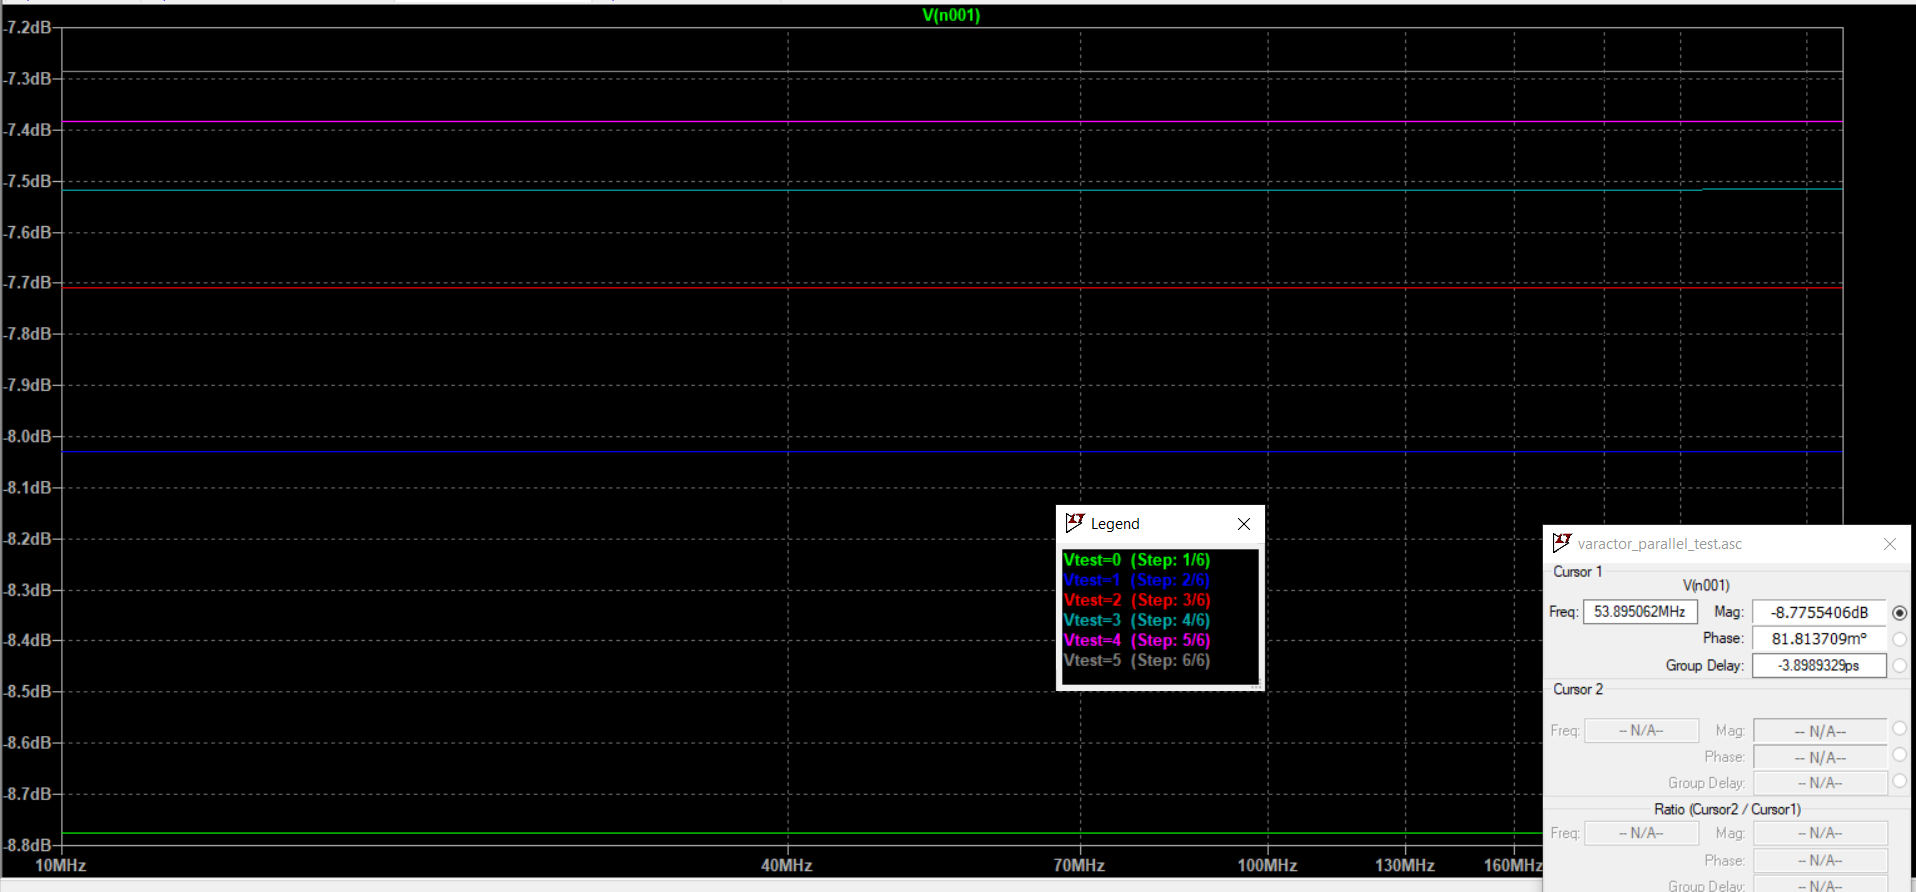

The SMV1130 has a larger range of around 3.1 dB => This is large enough. 
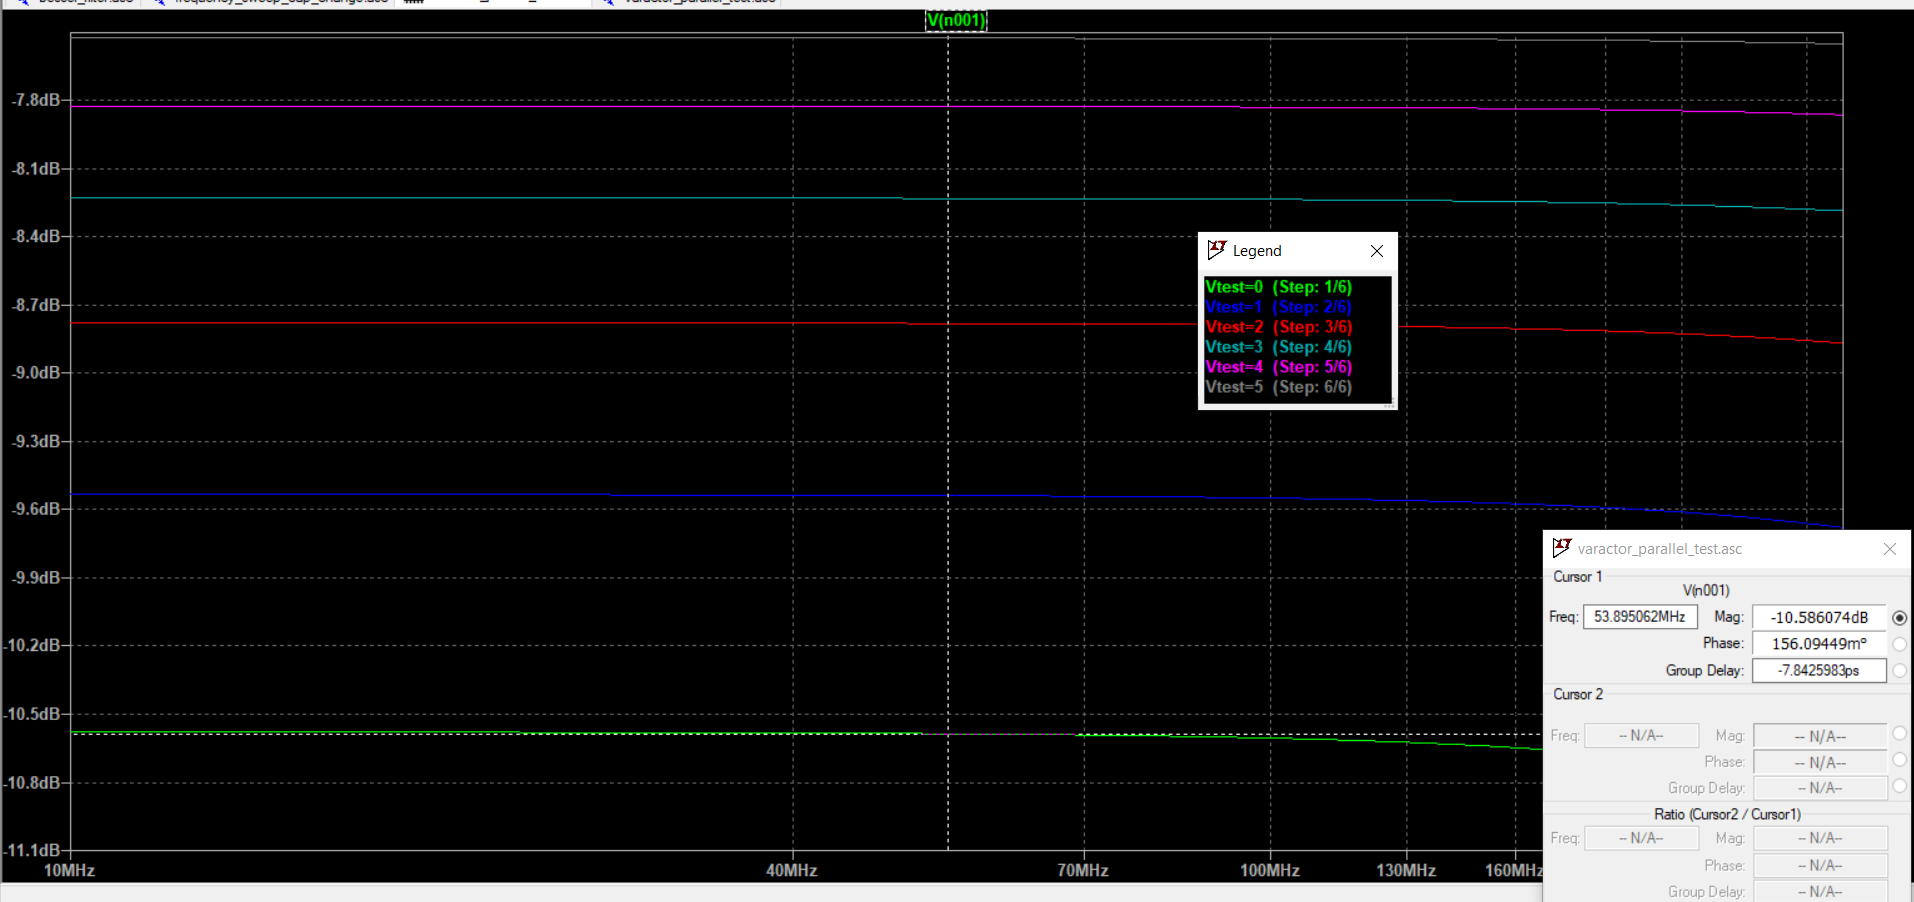

There is a slight dip starting at around 100 MHz, which might result in a small change in the filter characteristics at our freq. of interest (88 - 108 MHz), but it should probably be fine.

So now all we need to do is map this to the range -6.02 to -8.3 dB. Technically, with an infinite reverse bias, we should be able to get this to -6.02 dB. However, that's not realistic (and also the datasheet says 26V max reverse bias), so a better solution would be to lower the fixed capacitor in parallel to get an equivalent cap. value. 

The datasheet gives a table  and graph of cap. vs. reverse voltage. 

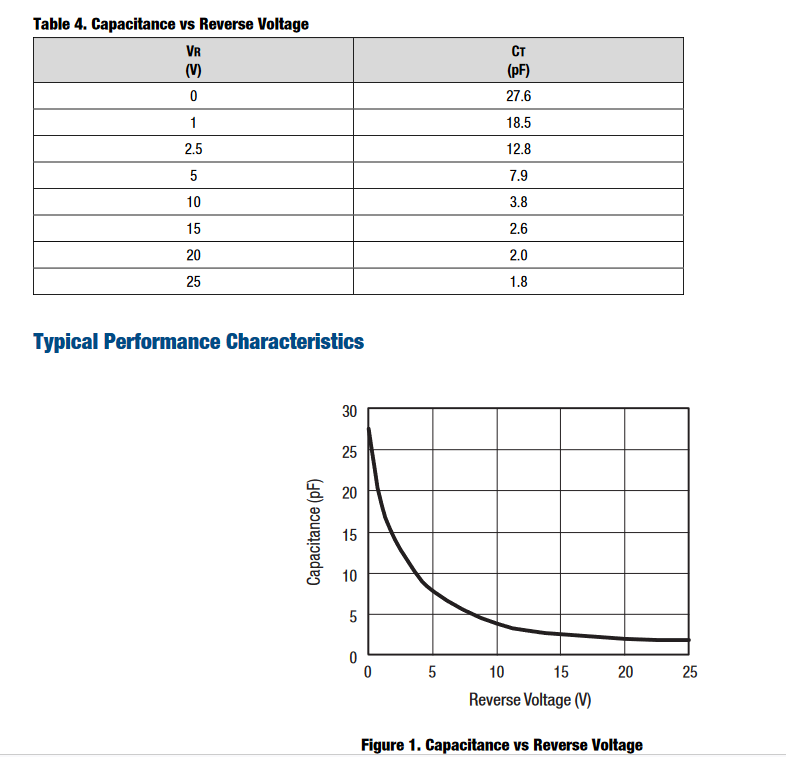

Let's choose 5V as the max reverse voltage. This gives us a cap of 7.9 pF. The parallel combination (which adds for caps) of the unknown cap and 7.9 pF is 21.65 pF, which means the unknown cap is 13.75 pF. When trying to acheive a total cap of 1.6*21.65 pF = 34.64 pF using the 13.75 pF cap, this gives us 34.64 - 13.75 = 20.89 pF which corresponds to a reverse bias of around 0.8V (need to simulate to find exact value corresponding to -8.3 dB).

The simulation for a reverse bias of 5V gives us a cap that is slightly less than -6.02 dB - it's around -5.95 dB. That's probably close enough for now.  

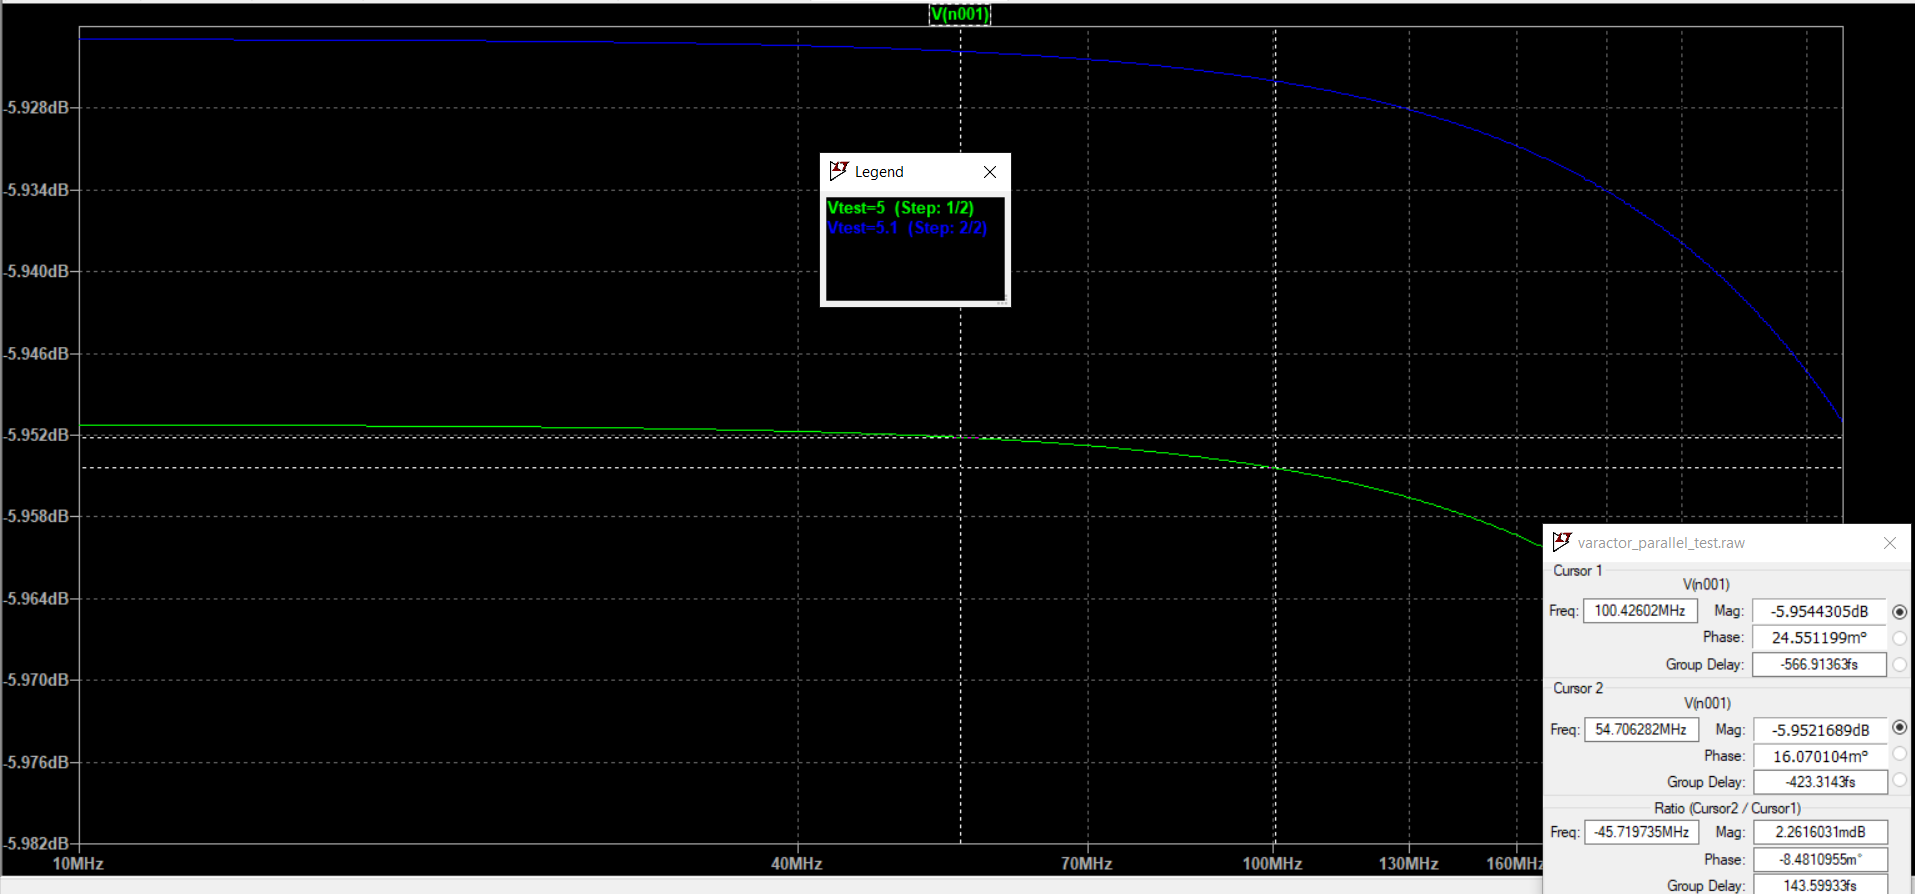

However, this capacitance will not be small enough for the other caps in the fF range. It doesn't seem like discrete varactors can generally produce capacitances that low. Maybe we can use a smaller inductor, so that we can use a larger capacitor for the same frequency? From a quick search on digikey, it doesn't seem like varactors with larger capacitances in the high pF or low nF range that can operate at high frequencies are easily available. 

Ok, it seems like it's pretty hard to make a 5th order passive filter without doing complicated switched capacitor circuits or something like that. Let's just go with a second order filter for now. This will make chooosing our component values a LOT easier.

To control the large caps, we could use two varactors in parallel to create an even larger cap, or use two varactors in series.

Just a single LC tank circuit provides poor rolloff/attenutation at other frequencies. But if I use a second order one, I have to tune both capacitors using varactors. But I run into the same problem I mentioned earlier where the ratio of the capacitors are very larger so if I made the inductors smaller to make the capacitances bigger, there would be no capacitors available with a self resonant frequency above the desired frequency, and if I didn't make the capacitors bigger I can't find a varactor that goes down to capacitances that small.

A solution could be to stack 50 varactors in parallel, which will be very annoying.

Ok I think I'm just going to go with a simple LC filter for simplicity. Apparently most of the filtering is done at the IF anyway, so I think it should be fine. According to perplexity, most car radios just use a fixed wideband input filter from 88 to 108 MHz. 

Group delay is the derivative of phase with respect to frequency. In FM modulation, the transmitted signal is a function of the baseband signal plus the carrier, x(t) = cos(wct + integral(bb)). We can denote integral(bb) as phi(t). The frequency of the signal is dependent on the time derivative of the phase, or dphi(t)/dt. The frequency domain representation of this is just dphi(w)/d(w), or the group delay.

FINAL FILTER DESIGN

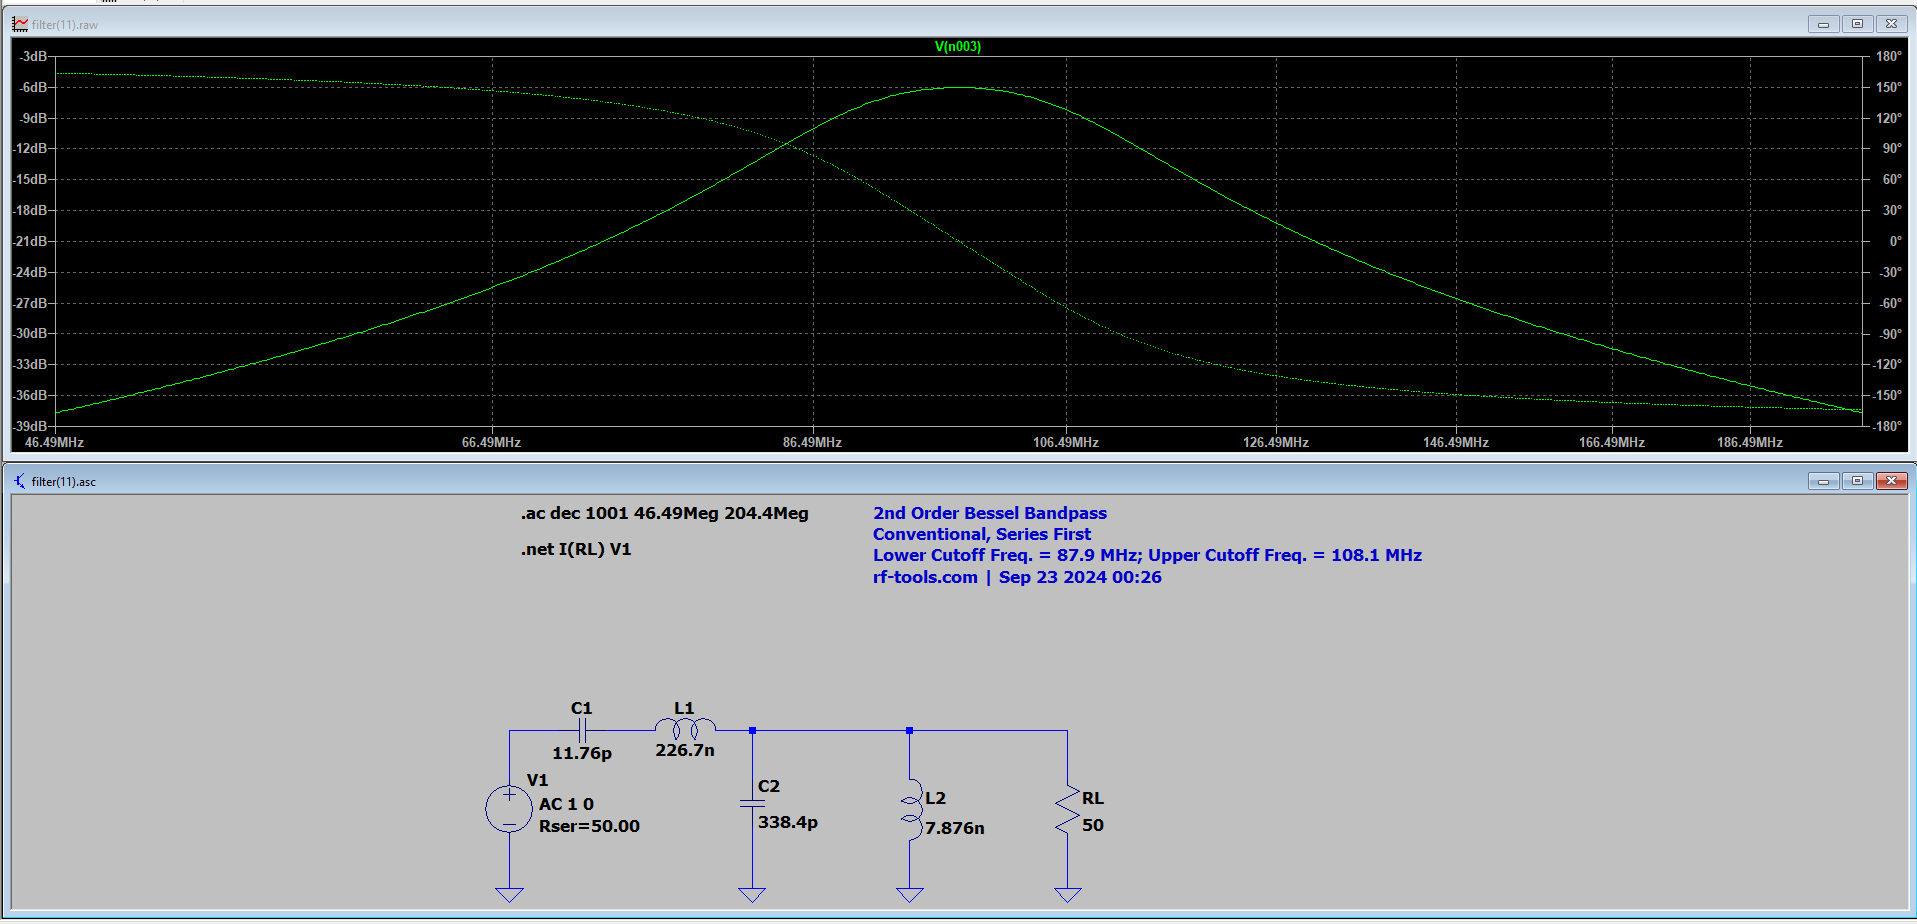

Using second order filter for more constant group delay instead of 5th order. Using bessel filter since it has the smallest group delay.

Sim with actual values from digikey: 
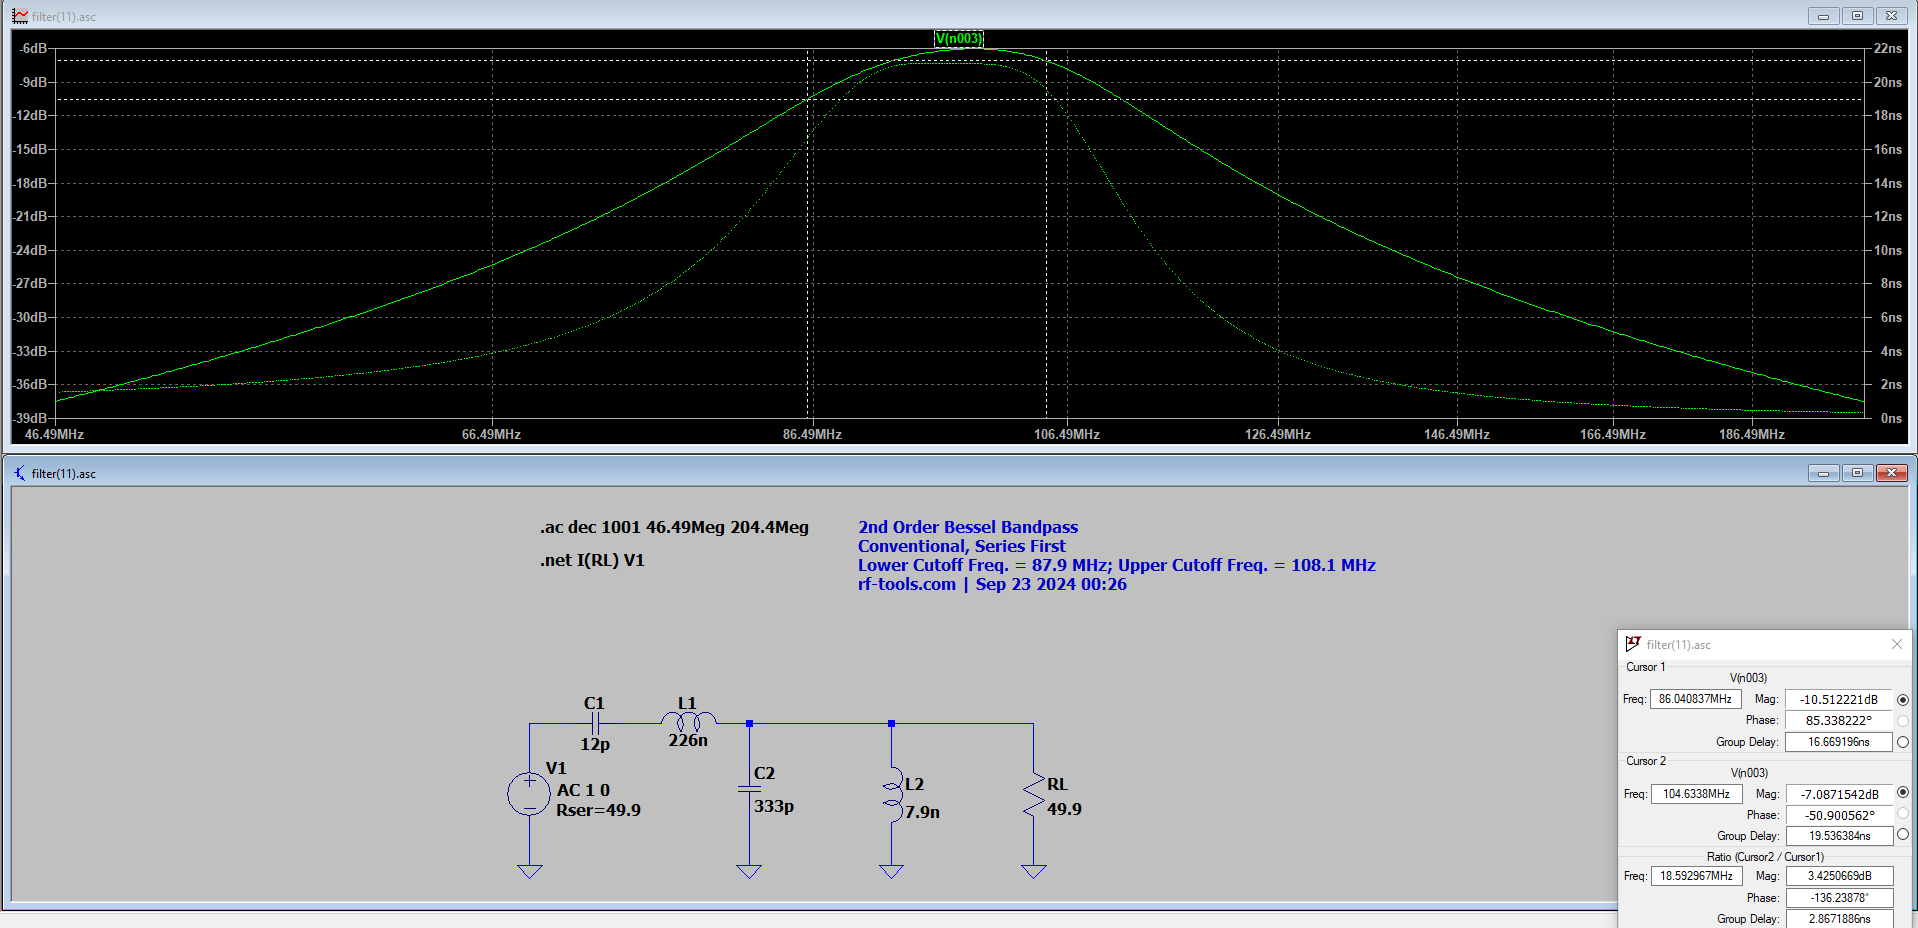